# Unsupervised Classification Analysis
## Marc Boulet
## Team Transparency, CSE 6242 Spring 2020


This notebook will take Team Transparency's merged dataset of country features and attempt to rank countries through unsupervised methods:
- k-means clustering  
- hierarchical clustering  
- DBSCAN  
- PCA of grouped attributes

## Recipe
1. Identify and eliminate highly correlated features
2. Transform your data if necessary
3. Hypothesize (in advance!) why things should cluster based on your EDA
4. Use a variety of unsupervised techniques to cluster your data
5. Use validation metrics to provide an unbiased measurement of clustering performance
6. Deliver some actionable insights

## Libraries and data load

In [155]:
# libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram

# helper modules
exec(open('helper_functions.py').read())

In [43]:
# load data
merged = pd.read_csv('../data/converted/merged.csv')
df = merged.copy()
df.head()

,year,gii_human_capital,country_iso,gii_domestic_credit,mobile_subscriptions,broadband_subscriptions_per100,gii_ict_services_imports,diversity_ethnicFractionalization,diversity_linguisticFractionalization,diversity_religiousFractionalization,...,gii_wikipedia_edits,gii_ict_access,gii_stem_assessment,poverty_ratio,foreign_investment,total_hospital_density_per_100k,gii_university_industry,gii_innovation_output,gdp_per_capta_usd,global_innovation_index
0,1960,NaN,ABW,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1961,NaN,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1962,NaN,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1963,NaN,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1964,NaN,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Initial data conditioning  

In [44]:
# remove all data prior to 2000
#df.drop(df[df.year < 2000].index, inplace = True)

In [45]:
# calculate feature mean over all years available (using mean to include outlier effects) 
df_mean = df.groupby('country_iso', as_index=False).mean()
# remove year column
df_mean.drop(['year'], axis = 1, inplace = True)
df_mean.head()

,country_iso,gii_human_capital,gii_domestic_credit,mobile_subscriptions,broadband_subscriptions_per100,gii_ict_services_imports,diversity_ethnicFractionalization,diversity_linguisticFractionalization,diversity_religiousFractionalization,literacy_rate,...,gii_wikipedia_edits,gii_ict_access,gii_stem_assessment,poverty_ratio,foreign_investment,total_hospital_density_per_100k,gii_university_industry,gii_innovation_output,gdp_per_capta_usd,global_innovation_index
0,ABW,NaN,NaN,38.400524,14.664502,NaN,0.0000,0.3889,0.4107,97.307103,...,NaN,NaN,NaN,NaN,3.200686,NaN,NaN,NaN,25444.983298,NaN
1,AFG,NaN,NaN,12.360732,0.011756,NaN,0.7693,0.6141,0.2717,30.972840,...,NaN,NaN,NaN,NaN,0.824011,0.37,NaN,NaN,575.652428,NaN
2,AGO,NaN,NaN,11.679964,0.183138,NaN,0.7867,0.7870,0.6276,66.717765,...,NaN,NaN,NaN,31.20,4.331602,NaN,NaN,NaN,4310.757348,NaN
3,ALB,22.7,35.0,31.171650,5.630488,1.5,0.2204,0.0399,0.4719,97.377008,...,16.0,5.3,415.2,1.14,4.359191,1.36,3.3,18.3,4475.868233,30.3
4,AND,NaN,NaN,33.022121,26.791824,NaN,0.7139,0.6848,0.2326,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39559.167382,NaN


## Feature identification and elimination
- remove all features that have a strong correlation (>0.5)


In [47]:
non_cultural = df_mean[['gii_domestic_credit',
                        'mobile_subscriptions',
                        'broadband_subscriptions_per100',
                        'gii_ict_services_imports',
                        'diversity_ethnicFractionalization',
                        'diversity_linguisticFractionalization',
                        'diversity_religiousFractionalization',
                        'literacy_rate',
                        'electrification',
                        'rural_population',
                        'school_enrollment_tertiary',
                        'gii_rule_of_law',
                        'population',
                        'mortality_rate',
                        'secure_internet_servers',
                        'gii_institutions',
                        'gii_top_level_domains',
                        'gii_research_talent_in_business',
                        'life_expectancy',
                        'ease_of_business',
                        'gii_ict_access',
                        'gii_stem_assessment',
                        'poverty_ratio',
                        'foreign_investment',
                        'total_hospital_density_per_100k',
                        'gii_university_industry',
                        'gdp_per_capta_usd', 
                        ]]


### Economic factors

In [48]:
eco = non_cultural[['gii_domestic_credit',
                    'ease_of_business',                 
                    'foreign_investment',
                    'gdp_per_capta_usd',
                    ]]

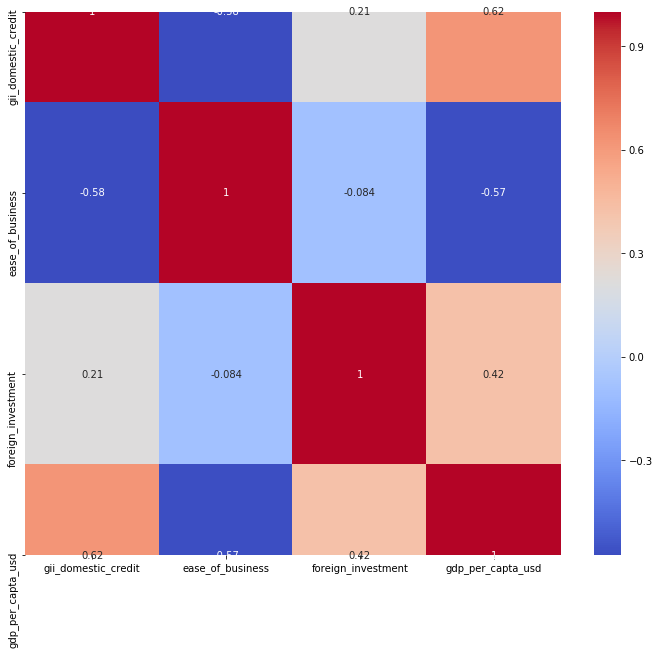

,gii_domestic_credit,ease_of_business,foreign_investment,gdp_per_capta_usd
gii_domestic_credit,1.000000,-0.575369,0.213173,0.619282
ease_of_business,-0.575369,1.000000,-0.084421,-0.566049
foreign_investment,0.213173,-0.084421,1.000000,0.424160
gdp_per_capta_usd,0.619282,-0.566049,0.424160,1.000000


In [49]:
plt.figure(figsize=(12,10))
cor = eco.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.coolwarm)
plt.show()
cor

In [50]:
# number of nulls per feature
eco.isnull().sum(axis=0)

gii_domestic_credit    145
ease_of_business        82
foreign_investment      25
gdp_per_capta_usd       65
dtype: int64

#### Economic factor conclusion:
- remove ease_of_business and gii_domestic_credit
- keep gdp_per_capta_used (fewer nulls)

In [54]:
# remove correlated economic factors
df_mean.drop(['ease_of_business', 'gii_domestic_credit'], axis = 1, inplace = True)
df_mean.shape

(271, 45)

### Demographic factors

In [57]:
dem = non_cultural[['diversity_ethnicFractionalization',
                    'diversity_linguisticFractionalization',
                    'diversity_religiousFractionalization',
                    'population',
                    'mortality_rate',
                    'life_expectancy',
                    'poverty_ratio'
                    ]]

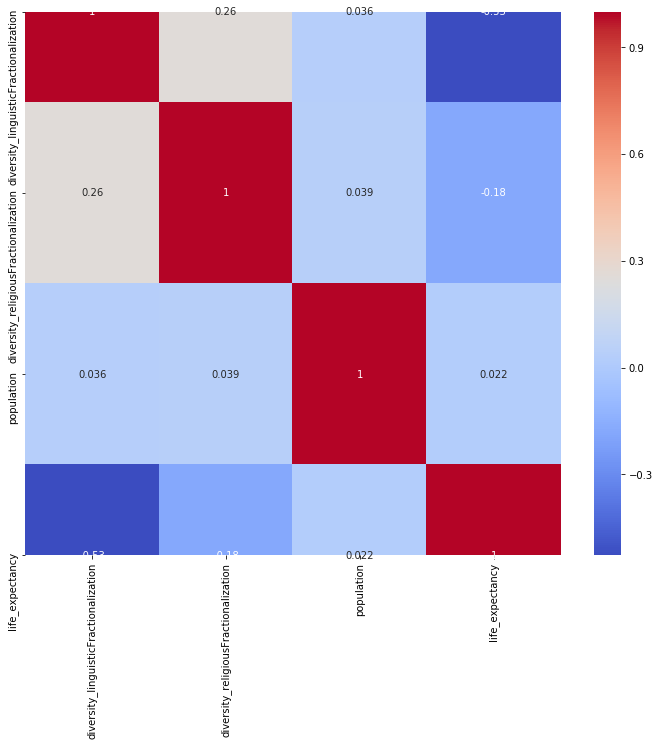

,diversity_linguisticFractionalization,diversity_religiousFractionalization,population,life_expectancy
diversity_linguisticFractionalization,1.000000,0.259644,0.035559,-0.528302
diversity_religiousFractionalization,0.259644,1.000000,0.039449,-0.176155
population,0.035559,0.039449,1.000000,0.022459
life_expectancy,-0.528302,-0.176155,0.022459,1.000000


In [63]:
plt.figure(figsize=(12,10))
cor = dem.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.coolwarm)
plt.show()
cor

In [46]:
# number of nulls per feature
dem.isnull().sum(axis=0)

diversity_ethnicFractionalization        65
diversity_linguisticFractionalization    65
diversity_religiousFractionalization     65
population                                8
mortality_rate                           79
life_expectancy                          74
poverty_ratio                            93
dtype: int64

### Demographic factor conclusion
- mortality_rate, life_expectancy, poverty_ratio highly-correlated 
- remove poverty_ratio and mortality_rate, due to higher nulls than life_expectancy
- diversity_ethnicFractionalization, diversity_linguisticFractionalization correlated
- remove diversity_ethnicFractionalization

In [64]:
# remove correlated demographic factors
df_mean.drop(['diversity_ethnicFractionalization',
                'mortality_rate',
                'poverty_ratio'], axis = 1, inplace = True)

### Infrastructure factors

In [94]:
inf = non_cultural[['mobile_subscriptions',
                    #'broadband_subscriptions_per100',
                    'gii_ict_services_imports',
                    #'literacy_rate',
                    #'electrification',
                    #'rural_population',
                    'school_enrollment_tertiary',
                    #'gii_rule_of_law',
                    'secure_internet_servers',
                    #'gii_institutions',
                    #'gii_top_level_domains',
                    #'gii_research_talent_in_business',
                    #'gii_ict_access',
                    #'gii_stem_assessment',
                    'total_hospital_density_per_100k',
                    #'gii_university_industry'             
                    ]]

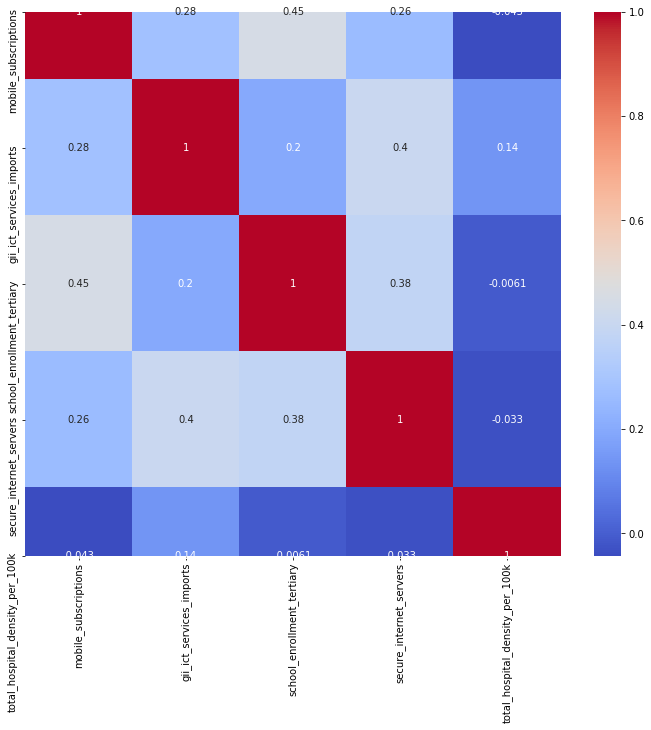

In [95]:
plt.figure(figsize=(12,10))
cor = inf.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.coolwarm)
plt.show()
#cor

In [69]:
# number of nulls per feature
inf.isnull().sum(axis=0)

mobile_subscriptions                11
broadband_subscriptions_per100      64
gii_ict_services_imports           143
literacy_rate                       65
electrification                     10
rural_population                    69
school_enrollment_tertiary          34
gii_rule_of_law                    142
secure_internet_servers             10
gii_institutions                   142
gii_top_level_domains              142
gii_research_talent_in_business    185
gii_ict_access                     145
gii_stem_assessment                200
total_hospital_density_per_100k    136
gii_university_industry            146
dtype: int64

In [ ]:
#### Infrastructure factor conclusion
remove broadband_subscriptions_per100, gii_ict_access, gii_institutions, gii_rule_of_law, gii_stem_assessment all highly-correlated (R2 > 0.75)
- electrification and literacy_rate highly correlated (0.78)
- remove rural_population, literacy_rate, electrification
- remove gii_research_talent_in_business, gii_top_level_domains, gii_university_industry

In [87]:
# remove correlated infrastructure factors
df_mean.drop(['broadband_subscriptions_per100',
                'gii_ict_access',
                'gii_institutions',
                'gii_rule_of_law',
                'gii_stem_assessment',
                'electrification',
                'literacy_rate',
                'rural_population',
                'gii_research_talent_in_business',
                'gii_top_level_domains',
                'gii_university_industry'
                ], axis = 1, inplace = True)
df_mean.shape

(271, 31)

### Cultural factors

In [92]:
cultural = df_mean[[#'gii_human_capital',
                    'gii_scientific_publications',
                    #'rd_in_gdp',
                    'creative_svc_audiovisual',
                    'creative_svc_other_personal_cultural_recreational',
                    'creative_svc_advertising_mktresearch_polling',
                    'creative_svc_architectural_engineering_technical',
                    #'creative_svc_personal_cultural_recreational',
                    'creative_svc_research',
                    'gii_creative_services', 
                    'gii_patent_applications',
                    'feature_films_produced',
                    #'gii_patent_families',
                    'gii_mobile_apps',
                    'cultural_occupation',
                    'gii_creative_goods',
                    #'gii_wikipedia_edits',
                    #'gii_innovation_output',
                    ]]

# did not include 'global_innovation_index' in the analysis

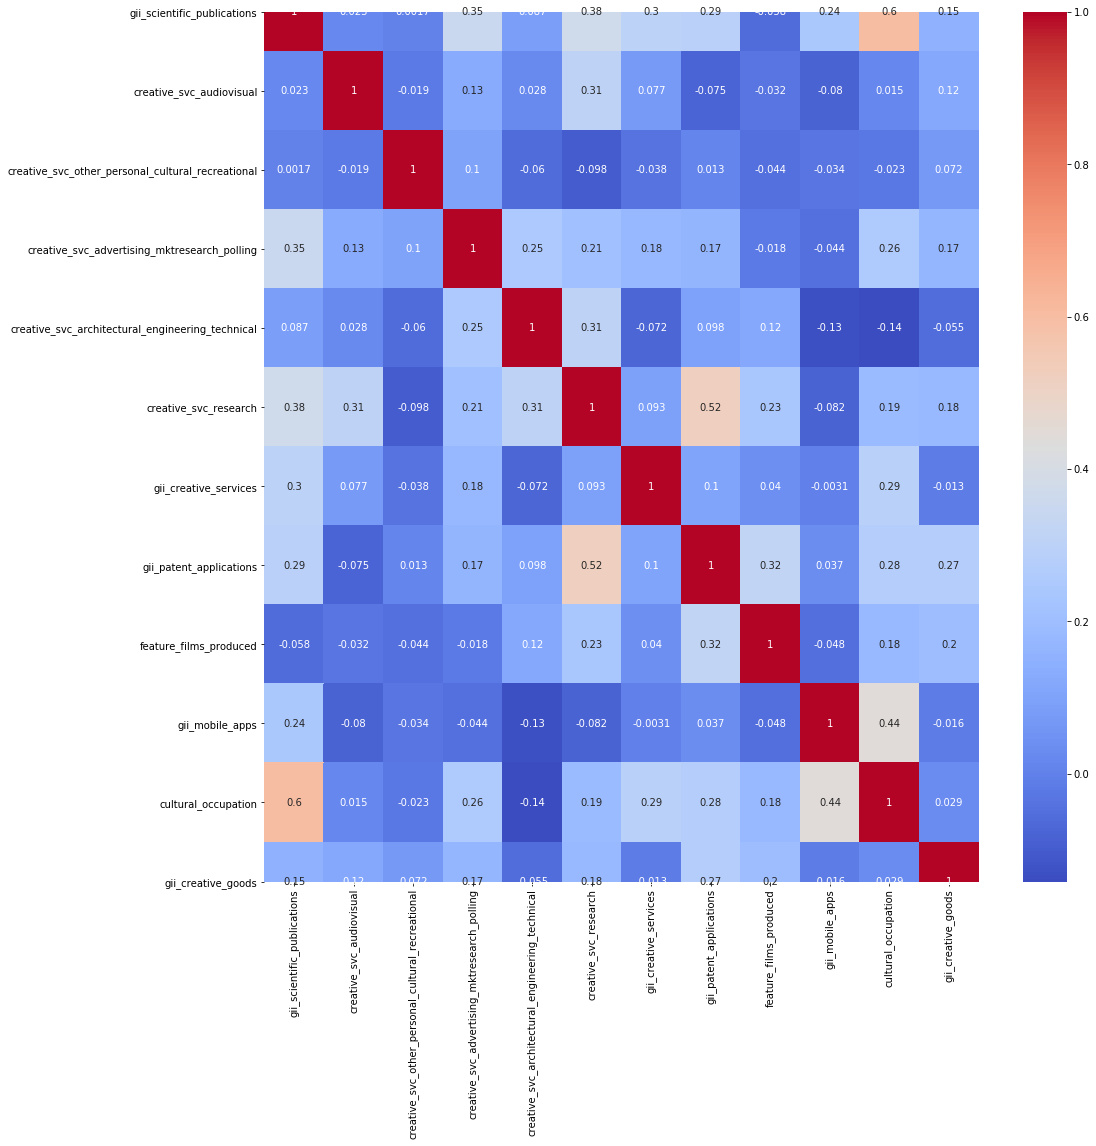

In [93]:
# cultural factor correlation
plt.figure(figsize=(16,16))
cor = cultural.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.coolwarm)
plt.show()
#cor

In [67]:
# number of nulls per feature
cultural.isnull().sum(axis=0)

gii_human_capital                                    142
gii_scientific_publications                          143
rd_in_gdp                                            147
creative_svc_audiovisual                             183
creative_svc_other_personal_cultural_recreational    167
creative_svc_advertising_mktresearch_polling         178
creative_svc_architectural_engineering_technical     192
creative_svc_personal_cultural_recreational          130
creative_svc_research                                199
gii_creative_services                                152
gii_patent_applications                              145
feature_films_produced                               154
gii_patent_families                                  148
gii_mobile_apps                                      173
cultural_occupation                                  202
gii_creative_goods                                   143
gii_wikipedia_edits                                  144
gii_innovation_output          

#### Cultural factor conclusion
- get rid of patent_families (high correlation with rd_in_gdp and gii_patent_applications)
- get rid of gii_innovation_output (high correlation with gii_human_capital and rd_in_gdp)
- get rid of creative_svc_personal_cultural_recreational (high correlation with creative_svc_audiovisual and creative_svc_other_personal_cultural_recreational)


In [96]:
# remove correlated infrastructure factors
df_mean.drop(['gii_human_capital',
                'rd_in_gdp',
                'creative_svc_personal_cultural_recreational',
                'gii_patent_families',
                'gii_wikipedia_edits',
                'gii_innovation_output'
                ], axis = 1, inplace = True)
df_mean.shape

(271, 25)

### combine all features for final correlation check

In [132]:
df_small = df_mean.copy()

# removed these features due to high correlations
df_small.drop([ 'global_innovation_index',
                'gii_scientific_publications',
                'life_expectancy',
                'gii_mobile_apps'
                ], axis = 1, inplace = True)

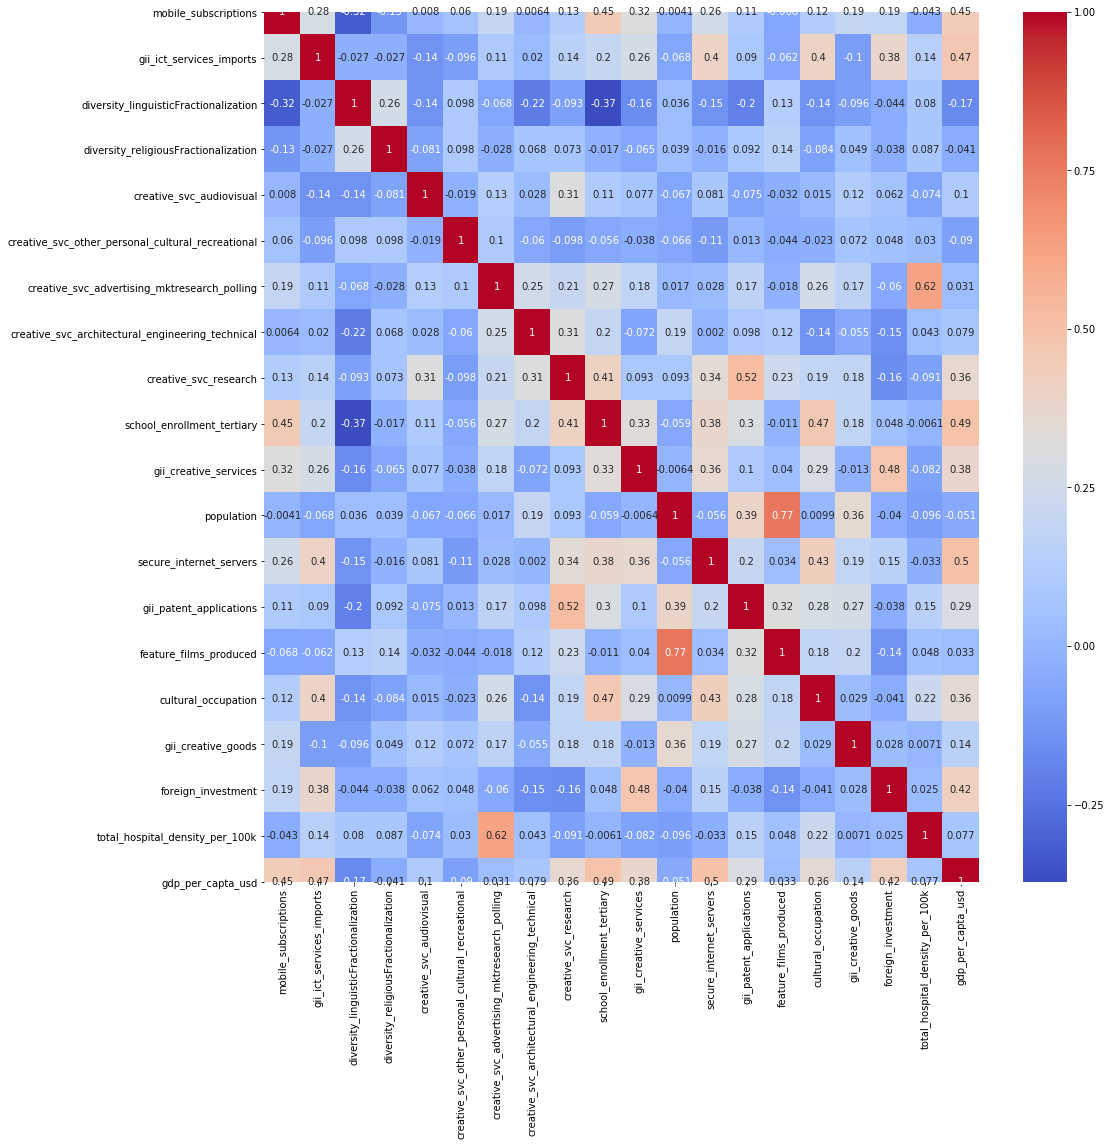

In [129]:
# remaining factor correlations
plt.figure(figsize=(16,16))
cor = df_small.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.coolwarm)
plt.show()
#cor

In [130]:
# number of nulls per feature
df_small.isnull().sum(axis=0)

country_iso                                            0
mobile_subscriptions                                  11
gii_ict_services_imports                             143
diversity_linguisticFractionalization                 65
diversity_religiousFractionalization                  65
creative_svc_audiovisual                             183
creative_svc_other_personal_cultural_recreational    167
creative_svc_advertising_mktresearch_polling         178
creative_svc_architectural_engineering_technical     192
creative_svc_research                                199
school_enrollment_tertiary                            34
gii_creative_services                                152
population                                             8
secure_internet_servers                               10
gii_patent_applications                              145
feature_films_produced                               154
cultural_occupation                                  202
gii_creative_goods             

### Prepare dataframe for classification

In [134]:
# removed 26 highly correlated features
# from 47 to 21 features
df_small.shape

(271, 21)

In [135]:
# impute remaining nulls with median feature value
df_small = df_small.fillna(df_small.median(axis = 0))

In [136]:
# # number of nulls per country
df_small.isnull().sum(axis=1)

0      0
1      0
2      0
3      0
4      0
      ..
266    0
267    0
268    0
269    0
270    0
Length: 271, dtype: int64

In [137]:
# Write to .csv file
df_small.to_csv('../data/converted/df_small.csv',index=False)

## k-means clustering

In [163]:
df_scaled = df_small.copy()

# scale numeric features
scaler = StandardScaler()
df_scaled.loc[:,df_scaled.columns != 'country_iso'] = scaler.fit_transform(df_scaled.loc[:,df_scaled.columns != 'country_iso'].to_numpy())

In [164]:
df_scaled.drop(['country_iso'], axis = 1, inplace = True)

In [170]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(df_scaled)

C:\Users\mboulet\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\mboulet\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\mboulet\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationW

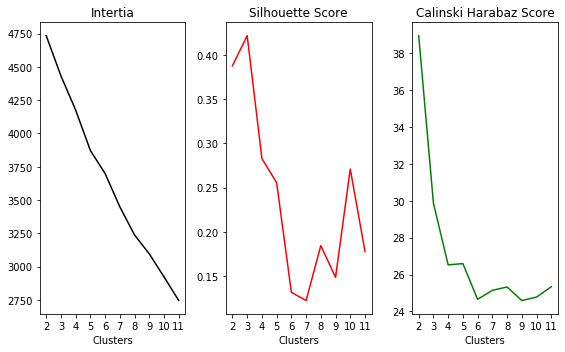

In [171]:
kmeans_elbowplot(df_scaled)

In [172]:
kmeans.cluster_centers_

array([[-0.34792445, -0.2445637 ,  0.16080464,  0.04386295, -0.10034338,
        -0.01230049, -0.18284984, -0.1300415 , -0.18485211, -0.39869813,
        -0.27081956,  0.05611009, -0.28429127, -0.19813343, -0.13810759,
        -0.19932144, -0.17090305, -0.09532191,  0.0147389 , -0.35677953],
       [ 1.71797206, -0.1486317 , -0.32215838, -0.21805649, -0.16801941,
        -0.21479851, -0.19532307, -0.15556092, -0.15333437,  0.23796208,
        -0.18021203, -0.30940854,  1.10469775, -0.20029793, -0.17661712,
        -0.30616038, -0.28790538, 11.50735905, -0.15572742,  4.3398765 ],
       [ 1.09579733,  0.69393697, -0.4535804 , -0.24190217, -0.02761772,
         0.09526417,  0.353746  ,  0.18721705, -0.17270241,  1.04220496,
         0.68962027, -0.17962839,  0.82577305,  0.07457867, -0.10405987,
         0.47376385,  0.29554627, -0.04796083, -0.01768353,  0.88002527],
       [ 0.32401519,  0.65964639, -0.39050496,  0.31599172,  1.35768772,
        -0.14840219,  1.07118027,  0.98515003,  

In [173]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 2, 3, 0, 0, 3, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 3, 2, 2, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 2, 1, 2, 2, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 3, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 2,
       3, 2, 0, 0, 2, 2, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 3, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       0, 0, 2, 0, 2, 0, 2, 3, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0,
       0, 0, 0, 0, 2, 2, 3, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [194]:
kmeans_results = pd.DataFrame(data=kmeans.labels_, columns = ['cluster'])

In [195]:
kmeans_results['country_iso'] = df_small['country_iso']

In [196]:
kmeans_results

,cluster,country_iso
0,0,ABW
1,0,AFG
2,0,AGO
3,0,ALB
4,0,AND
...,...,...
266,0,XKX
267,0,YEM
268,0,ZAF
269,0,ZMB


In [197]:
# Write to .csv file
kmeans_results.to_csv('../data/converted/kmeans_results.csv',index=False)

### TODO
- try kmeans on cultural and non-cultural datasets
- try DBSCAN
- try hierarchical clustering

### PCA
#### try pca on cultural and non-cultural datasets for dimensionality reduction

In [ ]:
#plot_pca_variance(pca)